# Error site and 3' end phasing

In this notebook we are going to take the differential error sites which are found at methylated positions, and identify whether there is a correlation between the VIRc basecalls at these sites and the positions of the 3' ends of the read. In this way we can try to "phase" the methylation with 3' site choice.

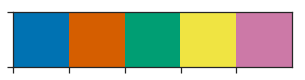

In [3]:
import sys
import os
from glob import glob
import random
from bisect import bisect_left
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib_venn as vn
import seaborn as sns

from statsmodels.stats.multitest import multipletests
from scipy.ndimage.filters import gaussian_filter1d
import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [4]:
def argrelmin_left_on_flat(arr, order):
    idx = []
    for i in range(order, len(arr) - order):
        if np.all(arr[i] < arr[i - order: i]) and np.all(arr[i] <= arr[i + 1: i + 1 + order]):
            idx.append(i)
    return np.array(idx)


def cluster_by_endpoint(endpoints, *, sigma):
    offset = endpoints.min() - sigma * 3
    endpoints_scaled = endpoints - offset
    endpoints_max = endpoints_scaled.max()
    endpoints_dist = np.bincount(
        endpoints_scaled,
        minlength=endpoints_max + sigma * 3
    ).astype('f')
    endpoints_dist = gaussian_filter1d(
        endpoints_dist, sigma=sigma, mode='constant', cval=0
    )

    # find local minima in three prime positions
    cut_idx = argrelmin_left_on_flat(endpoints_dist, order=sigma)
    cut_idx = cut_idx + offset

    # classify alignments in relation to local minima
    cluster_idx = []
    clusters = defaultdict(list)
    for pos in endpoints:
        i = bisect_left(cut_idx, pos)
        cluster_idx.append(i)
        clusters[i].append(pos)

    cluster_labels = {}
    for idx, positions in clusters.items():
        cluster_labels[idx] = f'{min(positions)}-{max(positions)}'
    return np.array(cluster_idx), cluster_labels


def iter_der_bed(der_sites_fn):
    with open(der_sites_fn) as bed:
        for record in bed:
            chrom, start, end, _, _, strand, *_ = record.split('\t')
            start = int(start)
            end = int(end)
            yield chrom, start, end, strand


def get_single_query_seq(pileupread):
    '''
    Get the query sequence for a pysam PileUpRead
    '''
    pos = pileupread.query_position
    if pos is None:
        return ''
    else:
        seq = pileupread.alignment.query_sequence[pos]
        if len(seq) > 1:
            return ''
        else:
            return seq


def get_query_seqs(pileupcol):
    # Use pysam to get the query sequences, or if this fails fall
    # back on slower but more stable method of fetching one at a time
    try:
        query_seqs = pileupcol.get_query_sequences()
    except AssertionError:
        query_seqs = [get_single_query_seq(read) for read in pileupcol.pileups]
    query_seqs = [s.upper() if s else 'indel' for s in query_seqs]
    return query_seqs



def iter_pileupreads(pileupcol):
    query_seqs = get_query_seqs(pileupcol)
    for read, seq in zip(pileupcol.pileups, query_seqs):
        aln = read.alignment
        if not read.is_refskip:
            three_prime, strand = (aln.reference_start, '-') if aln.is_reverse \
                                   else (aln.reference_end, '+')
            yield seq, strand, three_prime


def calculate_mismatch_odds_ratio(ref_base, kd_counts, cntrl_counts):
    '''
    Calculate the log2 odds ratio with haldane correction
    (0.5 pseudocount)
    '''
    try:
        kd_m = float(kd_counts[ref_base])
    except KeyError:
        kd_m = 0.0
    kd_mm = float(kd_counts.sum() - kd_m)

    try:
        cntrl_m = float(cntrl_counts[ref_base])
    except KeyError:
        cntrl_m = 0.0
    cntrl_mm = float(cntrl_counts.sum() - cntrl_m)
    odds_ratio = np.log2(((kd_mm + 0.5) / (kd_m + 0.5)) / 
                         ((cntrl_mm + 0.5) / (cntrl_m + 0.5)))
    return odds_ratio, [ref_base, kd_mm, kd_m, cntrl_mm, cntrl_m]


def get_pa_site_wise_res(counts, fasta, chrom, start, end, strand):
    ref_base = fasta.fetch(chrom, start, end)
    p = counts.index.to_series().str.split('-', expand=True)[0].astype('i')
    orders = np.argsort(p)
    if strand == '-':
        orders = orders.max() - orders
    for pa_site, order in zip(counts.index, orders):
        one_vs_rest = [counts.loc[pa_site], counts[counts.index != pa_site].sum()]
        log_odds, _ = calculate_mismatch_odds_ratio(ref_base, *one_vs_rest)
        g_stat, p_val, *_ = stats.chi2_contingency(one_vs_rest, lambda_='log-likelihood')
        yield pa_site, g_stat, p_val, log_odds, order


def phase_three_prime_ends(bam_fn, fasta_fn, der_sites_fn, sigma, min_reads_per_three_prime_cluster):
    derwise_res = []
    pawise_res = []
    count_data = {}
    with pysam.AlignmentFile(bam_fn) as bam, pysam.FastaFile(fasta_fn) as fasta:
        for chrom, start, end, der_strand in iter_der_bed(der_sites_fn):
            # for each read alignment overlapping this error site, identify the basecall at
            # this position and the position of the three prime end.
            seqs = []
            three_prime_positions = []
            for col in bam.pileup(chrom, start, end, truncate=True,
                                  max_depth=10_000_000, min_base_quality=0):
                for seq, aln_strand, three_prime in iter_pileupreads(col):
                    if aln_strand == der_strand:
                        seqs.append(seq)
                        three_prime_positions.append(three_prime)
            three_prime_positions = np.array(three_prime_positions)
            # cluster the read endpoints using KDE minima splitting
            three_prime_codebook, codebook_labels = cluster_by_endpoint(three_prime_positions, sigma=sigma)
            tpe_counts = np.bincount(three_prime_codebook)
            # filter out any small clusters of endpoints
            small_cluster_mask = tpe_counts[three_prime_codebook] >= min_reads_per_three_prime_cluster
            three_prime_positions = three_prime_positions[small_cluster_mask]
            three_prime_codebook = three_prime_codebook[small_cluster_mask]
            three_prime_codebook = [codebook_labels[idx] for idx in three_prime_codebook]
            seqs = [s for m, s in zip(small_cluster_mask, seqs) if m]
            n_clusters = len(set(three_prime_codebook))
            if n_clusters > 1:
                # generate a counts matrix of basecalls for each cluster
                counts = pd.crosstab(pd.Series(three_prime_codebook), pd.Series(seqs))
                # identify if there are differences in basecalls for the different clusters
                g_stat, p_val, *_ = stats.chi2_contingency(counts, lambda_='log-likelihood')
                derwise_res.append([chrom, start, end, der_strand, n_clusters, g_stat, p_val])
                for pa_site, g_stat, p_val, log_odds, order in get_pa_site_wise_res(counts, fasta, chrom, start, end, der_strand):
                    pawise_res.append([pa_site, chrom, start, end, der_strand, order, n_clusters, log_odds, g_stat, p_val])
                count_data[(chrom, start, end, der_strand)] = counts
    derwise_res = pd.DataFrame(derwise_res, columns=['chrom', 'start', 'end', 'strand', 'n_three_prime_clusters', 'g_stat', 'p_val'])
    _, derwise_res['fdr'], *_ = multipletests(derwise_res.p_val, method='fdr_bh')
    pawise_res = pd.DataFrame(pawise_res, columns=['pa_site', 'chrom', 'start', 'end', 'strand',
                                                   'three_prime_order', 'n_three_prime_clusters',
                                                   'log_odds', 'g_stat', 'p_val'])
    _, pawise_res['fdr'], *_ = multipletests(pawise_res.p_val, method='fdr_bh')
    return derwise_res, pawise_res, count_data

In [5]:
der_phasing_res, pasite_phasing_res, count_data = phase_three_prime_ends(
    '/cluster/ggs_lab/mtparker/analysis_notebooks/chimeric_transcripts/vir1_vs_VIRc/aligned_data/VIRc.merged.bam',
    '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa',
    '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed',
    sigma=13,
    min_reads_per_three_prime_cluster=10
)

In [ ]:
directionality = (
    pasite_phasing_res
    .groupby(['chrom', 'start', 'end', 'strand'])
    .apply(lambda df: stats.spearmanr(df.three_prime_order, df.log_odds)[0])
    .rename('directionality')
    .fillna(0) # nans result from flat log odds
    .reset_index()
)
directionality.head()

In [ ]:
der_phasing_res_dir = der_phasing_res.merge(
    directionality, on=['chrom', 'start', 'end', 'strand'], how='left')
der_phasing_res_dir.head()

In [ ]:
plt.hist(der_phasing_res_dir.p_val, bins=50)
plt.show()

In [ ]:
plt.hist(pasite_phasing_res.p_val, bins=50)
plt.show()

In [ ]:
%%bash
bedtools intersect -u -s \
  -a DER_sites_phased.bed \
  -b /cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/motif_detection/der_motifs.gtf > \
DER_motifs_phased_at_m6a_motifs.bed

In [ ]:
phasing_m6a = pd.read_csv(
    'DER_motifs_phased_at_m6a_motifs.bed',
    sep='\t', header=None,
    names=['chrom', 'start', 'end', 'name', 'g_stat', 'strand',
           'n_three_prime_clusters', 'p_val', 'fdr', 'directionality']
)
phasing_m6a.head()

In [ ]:
len(phasing_m6a)

In [476]:
%%bash
bedtools intersect -wa -wb -s \
  -a /cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/notebooks/araport_genes.bed \
  -b DER_motifs_phased_at_m6a_motifs.bed > genes_with_three_prime_phased_error_sites.bed

In [482]:
count_data[('1', 6402702, 6402703, '+')]

col_0,A,C,G,indel
row_0,,,,
6402710-6402750,14,0,13,0
6402763-6402824,14,3,51,4


In [491]:
genes_with_phased_error_sites = pd.read_csv(
    'genes_with_three_prime_phased_error_sites.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gene_id', 'score', 'strand',
           'chrom', 'start', 'end', 'name', 'g_stat', 'strand',
           'n_three_prime_clusters', 'p_val', 'fdr', 'directionality']
).groupby('gene_id', as_index=False).first()

/cluster/ggs_lab/mtparker/.conda/envs/r35py36/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [492]:
len(genes_with_phased_error_sites)

207

In [494]:
vir_vs_VIRc_differential_tpe = (pd.read_excel(
    '../three_prime_ends_in_cds_exons/vir1_vs_VIRc_differential_polya_site.xlsx'
).assign(abs_dist=lambda df: np.abs(df.dist_between_most_reduced_and_increased))
 .query('fdr < 0.05 & abs_dist >= 13'))
vir_vs_VIRc_differential_tpe.head()

,gene_id,start,end,strand,ks,pval,fdr,most_reduced_site,most_increased_site,dist_between_most_reduced_and_increased,abs_dist
8,AT1G01090,47233,49304,-,0.280613,2.159062e-27,2.257641e-25,47529,47612,-83,83
9,AT1G01100,49908,51210,-,0.048021,5.361359e-03,2.474354e-02,50097,50175,-78,78
13,AT1G01140,64165,67774,-,0.198144,3.189174e-03,1.619448e-02,64160,64314,-154,154
15,AT1G01170,73930,74737,-,0.107933,4.687481e-03,2.214051e-02,73996,74046,-50,50
23,AT1G01260,108945,111699,+,0.202360,3.295483e-03,1.664392e-02,111589,111539,-50,50


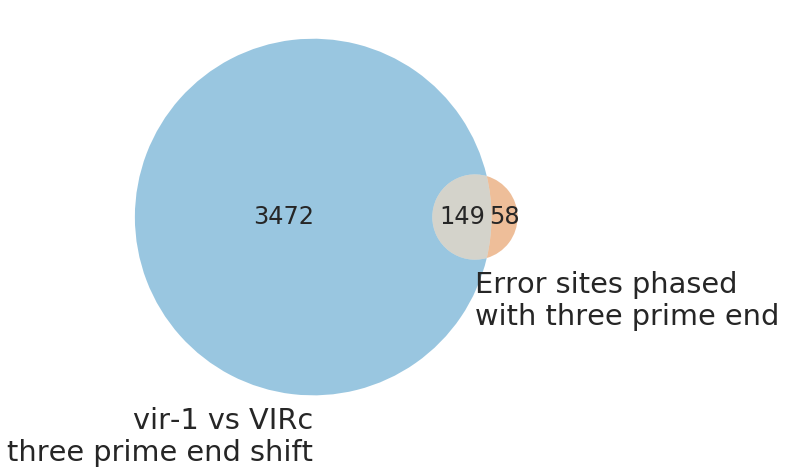

In [495]:
fig, ax = plt.subplots(figsize=(8, 8))
vn.venn2(
    [set(vir_vs_VIRc_differential_tpe.gene_id),
     set(genes_with_phased_error_sites.gene_id)],
    set_labels=['vir-1 vs VIRc\nthree prime end shift',
                'Error sites phased\nwith three prime end'],
    set_colors=pal[:2]
)

In [505]:
m = genes_with_phased_error_sites.merge(vir_vs_VIRc_differential_tpe, on='gene_id')
stats.spearmanr(
    m.directionality,
    m.dist_between_most_reduced_and_increased.map(lambda x: -1 if x > 0 else 1)
)

SpearmanrResult(correlation=0.38329459012911943, pvalue=1.40091009996134e-06)

In [475]:
def bam_cigar_to_invs(aln):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    for op, ln in aln.cigar:
        if op in (4, 5):
            # does not consume reference
            continue
        elif op in (0, 2, 7, 8):
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            invs.append([left, right])
            left = right + ln
            right = left
    if right > left:
        invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return np.array(invs)


def iter_pileupreads(pileupcol):
    query_seqs = get_query_seqs(pileupcol)
    for read, seq in zip(pileupcol.pileups, query_seqs):
        aln = read.alignment
        if not read.is_refskip:
            strand = '-' if aln.is_reverse else '+'
            invs = bam_cigar_to_invs(aln)
            yield seq, strand, invs


def phase_upstream_acceptor(bam_fn, der_sites_fn, sigma, min_reads_per_acceptor_cluster):
    res = []
    count_data = {}
    with pysam.AlignmentFile(bam_fn) as bam:
        for chrom, start, end, der_strand in iter_der_bed(der_sites_fn):
            # for each read alignment overlapping this error site, identify the basecall at
            # this position and the position of the three prime end.
            seqs = []
            acceptor_positions = []
            for col in bam.pileup(chrom, start, end, truncate=True,
                                  max_depth=10_000_000, min_base_quality=0):
                for seq, aln_strand, invs in iter_pileupreads(col):
                    if aln_strand == der_strand and len(invs) > 1:
                        if aln_strand == '+':
                            idx = np.searchsorted(invs[:, 0], col.reference_pos, side='right') - 1
                            acc_pos = invs[idx, 0]
                        else:
                            idx = np.searchsorted(invs[:, 1], col.reference_pos, side='left')
                            acc_pos = invs[idx, 1]
                        seqs.append(seq)
                        acceptor_positions.append(acc_pos)
            acceptor_positions = np.array(acceptor_positions)
            _, acceptor_codebook = np.unique(acceptor_positions, return_inverse=True)
            acc_counts = np.bincount(acceptor_codebook)
            # filter out any small clusters of acceptors
            small_cluster_mask = acc_counts[acceptor_codebook] >= min_reads_per_acceptor_cluster
            acceptor_positions = acceptor_positions[small_cluster_mask]
            seqs = [s for m, s in zip(small_cluster_mask, seqs) if m]
            n_clusters = len(set(acceptor_positions))
            if n_clusters > 1:
                # generate a counts matrix of basecalls for each cluster
                counts = pd.crosstab(pd.Series(acceptor_positions), pd.Series(seqs))
                # identify if there are differences in basecalls for the different clusters
                g_stat, p_val, *_ = stats.chi2_contingency(counts, lambda_='log-likelihood')
                res.append([chrom, start, end, der_strand, n_clusters, g_stat, p_val])
                count_data[(chrom, start, end, der_strand)] = counts
    res = pd.DataFrame(res, columns=['chrom', 'start', 'end', 'strand', 'n_acceptor_clusters', 'g_stat', 'p_val'])
    _, res['fdr'], *_ = multipletests(res.p_val, method='fdr_bh')
    return res, count_data

In [162]:
phasing_acceptor, acc_counts = phase_upstream_acceptor(
    '/cluster/ggs_lab/mtparker/analysis_notebooks/chimeric_transcripts/vir1_vs_VIRc/aligned_data/VIRc.merged.bam',
    '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/der_analysis/der_sites_thresholded.bed',
    sigma=15,
    min_reads_per_acceptor_cluster=10
)

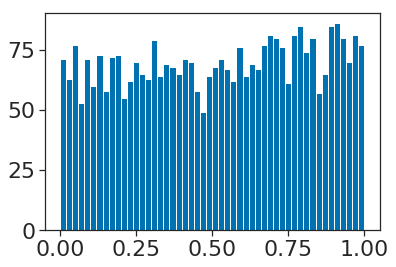

In [167]:
plt.hist(phasing_acceptor.p_val, bins=50)
plt.show()